# SIGNOR Analysis
Author: Vito Zanotelli

This analysis relates the hits of the BP-R2 analysis to the SIGNOR prior knowledge network. The aim is to find the shortest path between the overexpressed protein and the measured phospho-marker.

The description of the approach from the methods:

"""
To compare the consistency between the strong signaling relationships detected by BP-R2 analysis with the relationships predicted by the Signor database, the python NetworkX package was used to construct a sign-directed Signor network from the UniProt entries of overexpressed POIs and measured phosphoproteins. NetworkX also calculates a shortest path length within the sign-directed network. Antibodies may bind to the same phosphorylation sites on more than one protein from a family, making the mapping between antibodies and UniProt entries ambiguous. In this case, the shortest path value was calculated between the overexpressed POI and any possible antibody targets. 

The analysis was performed including the directionalities of signaling relationships as identified by the Spearman correlation of the bin medians in our analysis, and by exploiting the SIGNOR annotations in the following way: Simple paths between the overexpressed protein and the targeted phosphorylation sites were analyzed, starting from the shortest path to longer paths, until a sign-consistent path was found. To identify sign consistency, all edges in the SIGNOR network were classified as positive, negative, or ambiguous based on the SIGNOR ‘Effect’ annotation: down-regulates...=negative, up-regulates...=positive, something else=ambiguous. In cases for which there were multiple interaction types possible for an edge (positive and negative), the overall sign was taken to be ambiguous. In cases where the last edge was annotated to be affecting exactly the residue (SIGNOR annotation ‘Residue’) measured by the phospho-specific antibody through (de)phosphorylation (SIGNOR annotation ‘Mechanism’), the directionality sign of this edge was determined to be phosphorylation=positive, dephosphorylation=negative or the inverse in cases the antibody was measuring the non-phospho site (e.g., Ser33/37/Thr41 on Beta-catenin). Measured phosphorylation sites responsible for inactivating a protein (e.g., Ser9 on GSK3Beta) were also signed as phosphorylation=negative. A path was determined to be sign consistent if the product of the signs of all its edges was in accordance with the relationship direction as measured by the Spearman correlation over the bins.
"""

Note that the calulation of the shortest paths takes a while.


In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from IPython.display import display, HTML
import os
%matplotlib inline

In [2]:
# The complete signor network
signor_fn = './additional_data/20160110_signor_all_data.tsv'
# The antibody names in uniprot
antibody_fn = './additional_data/201610_antibody_uniprot.csv'
# ignored effects due to spillover
ignored_fn ='./additional_data/20161020_ignored_relations.csv'
# The overexpressions in uniprot
overexp_fn = './additional_data/201602_gene_uniprot.csv'

In [3]:
fn_bindat = '../example/example_output/main_full/bindat'

In [4]:
# Effect mechanism filters for signor
not_used_effects = pd.read_csv(ignored_fn)
not_used_markertarget = [row['marker']+row['target'] for idx,row in not_used_effects.iterrows()]
signor_tab = pd.read_csv(signor_fn, sep='\t')

Make a dict for the names

In [5]:
signor_dict = {k: v for k,v in zip(signor_tab['IdA'],signor_tab['EntityA'])}
signor_dict.update({k: v for k,v in zip(signor_tab['IdB'],signor_tab['EntityB'])})


Read the antibody and gene information

In [6]:
overexp_tab = pd.read_csv(overexp_fn)
overexp_tab.head(2)

overexp_dict = {k: v for k,v in zip(overexp_tab['gene_xkl'],overexp_tab['UniProt'])}

In [7]:
antibody_tab = pd.read_csv(antibody_fn)
antibody_tab.head(2)

antibody_dict= dict()
for ab, tab in antibody_tab.groupby('Antibody'):
    if not(tab['UniProt'].isnull().values.any()):
        antibody_dict[ab] = set(tab['UniProt'])
        
    

In [8]:
antibody_tab

,Isotope,Antibody,Antigen,Immunogen,Residue,Phospho,Supplier,Clone,Staining Concentration [μg/ml],UniProt
0,La139,p-CREB,p-CREB1,Ser133,Ser133,1,BD,J151-21,1.00,P16220
1,La139,p-CREB,p-AFT1,Ser63,Ser63,1,BD,J151-21,1.00,P18846
2,Pr141,p-STAT5,p-STAT5,Tyr694,Tyr694,1,BD,47/Stat5,2.00,P42229
3,Nd142,p-SHP2,p-SHP2,Tyr580,Tyr580,1,CST,D66F10,4.00,Q06124
4,Nd143,p-FAK,p-FAK,Tyr397,Tyr397,1,CST,Polyclonal,2.00,Q05397
5,Nd144,p-MEK1-2,p-MEK1,Ser221,Ser221,1,CST,166F8,2.00,Q02750
6,Nd144,p-MEK1-2,p-MEK2,Ser221,Ser221,1,CST,166F8,2.00,P36507
7,Nd145,p-MAPKAPK2,p-MAPKAPK2,Thr334,Thr334,1,CST,27B7,1.00,P49137
8,Nd146,p-p70S6K,p-p70S6K,Thr389,Thr389,1,CST,1A5,1.00,P23443
9,Sm147,p-MKK3,p-MKK3,Thr222,Thr222,1,Assay Biotechnology,Polyclonal,2.00,P46734


In [9]:
antibody_dict_extended= dict()
for ab, tab in antibody_tab.groupby('Antibody'):
    if not(tab['UniProt'].isnull().values.any()):
       cur_entry = [(row['UniProt'],row['Residue'].split('/'), row['Phospho'])  for idx, row in tab.iterrows()]
       antibody_dict_extended.update({ab: cur_entry})

# Generate the graph

It needs to be a multidigraph to allow for parallel edges

In [10]:
g = nx.MultiDiGraph()

for idx, row in signor_tab.iterrows():
    g.add_edge(row['IdA'], row['IdB'], attr_dict=dict((col, row[col]) for col in ['Effect', 'EffectMechanism',
       'MechanismResidues', 'MechanismSequences','Direct', 'Sentence']))

Check if the graph contains all measured antibodies/overexpressions

In [11]:
xkl_nodes = np.unique(overexp_tab['UniProt'].dropna().tolist() + antibody_tab['UniProt'].dropna().tolist())

all_nodes = g.nodes()
signor_xkl_nodes = [n for n in all_nodes if n in xkl_nodes]
len(signor_xkl_nodes) == len(xkl_nodes)

True

-> All relevant species are present

## Check the average shortest path length between overexpressions and phosphoproteins

Calculate pairwise shortest path distance, taking the minimum distance if the antibody is not specific

In [12]:
col = antibody_dict.keys()
row = overexp_tab['gene_xkl']

pair_sp = np.empty((len(row), len(col)))
pair_sp[:] = np.NAN
for i, over in enumerate(row):
    for j, ab in enumerate(col):
        sp = list()
        for ab_prot in antibody_dict[ab]:
            ov_prot = overexp_dict[over]
            try:
                sp.append(nx.shortest_path_length(g, ov_prot, ab_prot))
            except nx.NetworkXNoPath:
                pass
        if len(sp) > 0:
            pair_sp[i,j] = np.min(sp)
        else:
            pair_sp[i,j] = 10
 


pair_dat = pd.DataFrame(pair_sp,columns=col, index=row)
pair_dat = pair_dat.stack()
pair_dat.index = pair_dat.index.rename(['marker','target'])




# As proposed by the reviewer: make a signed version

Check for each shortest path which sign is predicted.

Save two versions: positive and negative

Algorithm: 
- Get all shortest path with  nx.all_shortest_paths(g, source, target)
- calculate the sign based on the annotation of the interaction
- If any 

Make a function that gives the shortest path given the network and a sign

In [13]:
def get_shortest_dir_path(graph, origin, target, mode, maxlen=6, target_residues=None, phospho_dir=1):

    cur_len = nx.shortest_path_length(graph, origin, target)
    
    if cur_len == 0:
        return [origin]
    while cur_len <= maxlen:
        pathgen = nx.all_simple_paths(graph, origin, target, cutoff=cur_len)
        
        prev_paths = set()
        for path in pathgen:
            path = tuple(path)
            if path not in prev_paths:
                curmode = get_overal_mode(graph, path, target_residues=target_residues, phospho_dir=phospho_dir)
                if (curmode == mode) | (mode == 0):
                    return path
                else:
                    prev_paths.add(path)
            
        cur_len += 1
            
    raise(nx.NetworkXNoPath)
    
def get_overal_mode(graph, nodes, target_residues=None, phospho_dir=1):
    """
    """
    if target_residues is None:
        target_residues = []
    modes = list()
    for i in range(len(nodes)-1):
        
        idx, edges = zip(*graph.edge[nodes[i]][nodes[i+1]].items())
        if (i == len(nodes)-2):
            ## for the last node, check if it is a phosphorylation and if any of the target sites is in there
            ## if it is, check if it is 'dephosphorylation' or 'phosphorylation' and set sign accordingly.
            ## default back to 'mode'
            curmod = set()
            for e in edges:
                if e['MechanismResidues'] in target_residues:
                    if e['EffectMechanism'] == 'phosphorylation':
                        curmod.add(phospho_dir)
                    elif e['EffectMechanism'] == 'dephosphorylation':
                        curmod.add(phospho_dir*-1)
                    else:
                        curmod.add(0)
                else:
                    curmod.add(e['mode']*phospho_dir)        
        else:
            # take the annotation mode as mode
            curmod = set(e['mode'] for e in edges)
        if len(curmod) > 1:
            return 0
        else:
            modes.append(curmod.pop())
            
    overal_mode = np.prod(modes)
    return overal_mode

Incorporate the information if it up or downregulates

In [14]:
g_updown = g.copy()
for e in set(g_updown.edges()):
    for key, item in g_updown.edge[e[0]][e[1]].items():
        e_dat = item
        if (e_dat['Effect'].startswith('down-regulates')):
            e_dat.update(({'mode':-1}))
        elif (e_dat['Effect'].startswith('up-regulates')):
            e_dat.update(({'mode':1}))
        else:
            e_dat.update(({'mode':0}))

Attention: The calculations in the next section can take 1h or more!!

In [15]:
def calc_disttable_signed(g, antibody, overexpression, direction, antibody_dict_ext, overexp_dict):
    col = antibody
    row = overexpression

    pair_tab = np.empty((len(row), len(col)))
    pair_tab[:] = np.NAN
    for i, over in enumerate(row):
        for j, ab in enumerate(col):
            sp = list()
            for ab_prot, target_resid, phospho_dir in antibody_dict_ext[ab]:
                ov_prot = overexp_dict[over]
                

                try:
                    sp.append(len(get_shortest_dir_path(g, ov_prot, ab_prot, direction,target_residues=target_resid,
                                                        phospho_dir=phospho_dir))-1)
                except nx.NetworkXNoPath:
                    1
            if len(sp) > 0:
                pair_tab[i,j] = np.min(sp)
            else:
                pair_tab[i,j] = np.NaN
    pair_dat = pd.DataFrame(pair_tab,columns=col, index=row)
    pair_dat = pair_dat.stack(dropna=False)
    pair_dat.index = pair_dat.index.rename(['marker','target'])
    return pair_dat
    


pair_dat_pos = calc_disttable_signed(g=g_updown,
                                    antibody=antibody_dict_extended.keys(), 
                      overexpression=overexp_tab['gene_xkl'],
                      direction=1,
                      antibody_dict_ext=antibody_dict_extended,
                      overexp_dict=overexp_dict
                     )
pair_dat_neg = calc_disttable_signed(g=g_updown, antibody=antibody_dict_extended.keys(), 
                      overexpression=overexp_tab['gene_xkl'],
                      direction=-1,
                      antibody_dict_ext=antibody_dict_extended,
                      overexp_dict=overexp_dict
                     )


## Check consistency with bp-R2 analysis

Compare how the the bp-R2 analysis hits fit into the Signor network. Towards the average distance within all possible marker pairs and the average distance in the hits. 

For the directed network, use the spearman correlation over the bin medians as a indication for directionality.

In [16]:
bin_dat = pd.read_pickle(fn_bindat)

### Look at relationships that are strong during at least one timepoint

In [17]:
sig_dat = bin_dat.loc[(bin_dat['bin_dat_sigfil'])].reset_index(drop=False)
sig_dat =sig_dat.groupby(['marker', 'target']).apply(lambda x: np.sign(x[('stats', 'corr_spearman_bin')].mean()))
sig_dat.name = 'sign'
sig_dat = sig_dat.reset_index(drop=False)
fil = (sig_dat['marker'].apply(lambda x: x in overexp_dict.keys())) & (
    sig_dat['target'].apply(lambda x: x in antibody_dict.keys()))


sig_dat = sig_dat.loc[fil]

2.63333333333
3.0


(array([  9.,  10.,  18.,  27.,  20.,   6.,   0.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5]),
 <a list of 7 Patch objects>)

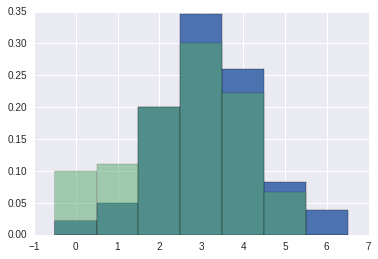

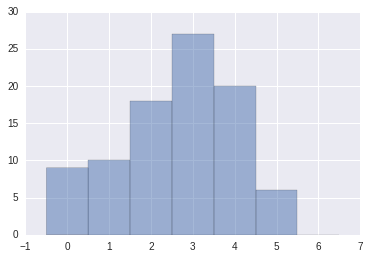

In [18]:
pair_dat_pos_neg = pair_dat_pos.append(pair_dat_neg).dropna()

fil = (pair_dat_pos_neg.index.get_level_values('marker').isin(not_used_effects['marker']) &
       pair_dat_pos_neg.index.get_level_values('target').isin(not_used_effects['target'])) == False 

bins = np.arange(int(np.ceil(pair_dat_pos_neg.max()))+2)-0.5
plt.hist(pair_dat_pos_neg.loc[fil], bins=bins,normed=True)


fil = (sig_dat['marker'].apply(lambda x: x in overexp_dict.keys())) & (
    sig_dat['target'].apply(lambda x: x in antibody_dict.keys())) & (sig_dat['marker'].isin(not_used_effects['marker']) &
       sig_dat['target'].isin(not_used_effects['target'])) == False 


def _get_data(x):
    if x['sign'] > 0:
        return(pair_dat_pos.loc[x['marker'], x['target']])
    else:
        return(pair_dat_neg.loc[x['marker'], x['target']])

sp_dist_hits_sign = sig_dat.loc[fil].apply(lambda x: _get_data(x),axis=1)

sp_dist_hits_nonsign = sig_dat.loc[fil].apply(lambda x: pair_dat.loc[x['marker'], x['target']],axis=1)

#plt.hist(sp_dist_hits_nonsign.dropna(), bins=bins,normed=True, alpha=0.5)
plt.hist(sp_dist_hits_sign.dropna(), bins=bins,normed=True, alpha=0.5)

sig_dat_0 = sig_dat.copy()
print(sp_dist_hits_sign.mean())
print(sp_dist_hits_sign.median())
plt.figure()
plt.hist(sp_dist_hits_sign.dropna(), bins=bins, alpha=0.5)

-> Looking over all timepoints is not optimal, as this includes relationships affecting the EGF stimulation dynamics, which could be quite indirect

### Look at relationships that are strong at steady state

In [19]:
sig_dat = bin_dat.loc[(bin_dat.index.get_level_values('timepoint') == 0) & (bin_dat['bin_dat_sigfil'])].reset_index(drop=False)
sig_dat =sig_dat.groupby(['marker', 'target']).apply(lambda x: np.sign(x[('stats', 'corr_spearman_bin')].mean()))
sig_dat.name = 'sign'
sig_dat = sig_dat.reset_index(drop=False)
fil = (sig_dat['marker'].apply(lambda x: x in overexp_dict.keys())) & (
    sig_dat['target'].apply(lambda x: x in antibody_dict.keys()))


sig_dat = sig_dat.loc[fil]

In [20]:
def get_notusedfil(mark, targ):
    cur = [m+t for m,t in zip(mark, targ)]
    fil = np.array([c not in not_used_markertarget for c in cur])
    return fil

mean distance hits at steady state 2.283333
mean distance network overall 3.172719


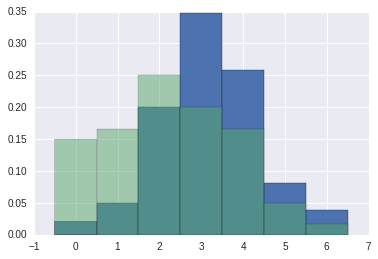

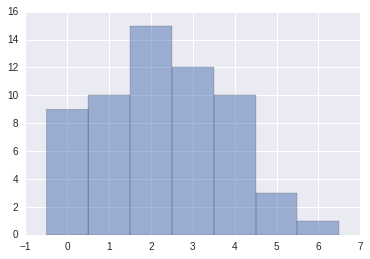

In [21]:
pair_dat_pos_neg = pair_dat_pos.append(pair_dat_neg).dropna()

fil = get_notusedfil(pair_dat_pos_neg.index.get_level_values('marker'), pair_dat_pos_neg.index.get_level_values('target'))

bins = np.arange(int(np.ceil(pair_dat_pos_neg.max()))+2)-0.5
pair_dat_pos_neg = pair_dat_pos_neg.loc[fil]
plt.hist(pair_dat_pos_neg, bins=bins,normed=True)


fil =  (sig_dat['marker'].apply(lambda x: x in overexp_dict.keys())) & (
    sig_dat['target'].apply(lambda x: x in antibody_dict.keys())) & get_notusedfil(sig_dat['marker'], sig_dat['target'])


def _get_data(x):
    if x['sign'] > 0:
        return(pair_dat_pos.loc[x['marker'], x['target']])
    else:
        return(pair_dat_neg.loc[x['marker'], x['target']])

sp_dist_hits_sign = sig_dat.loc[fil].apply(lambda x: _get_data(x),axis=1)

sp_dist_hits_nonsign = sig_dat.loc[fil].apply(lambda x: pair_dat.loc[x['marker'], x['target']],axis=1)

#plt.hist(sp_dist_hits_nonsign.dropna(), bins=bins,normed=True, alpha=0.5)
plt.hist(sp_dist_hits_sign.dropna(), bins=bins,normed=True, alpha=0.5)

sig_dat_0 = sig_dat.copy()
plt.figure()
plt.hist(sp_dist_hits_sign, bins=bins, alpha=0.5)

print('mean distance hits at steady state %f' %sp_dist_hits_sign.mean())
print('mean distance network overall %f' %pair_dat_pos_neg.mean())

-> Indeed strong relationships at steady state are quite strongly enriched

In [22]:


overexp_tab = overexp_tab.set_index('gene_xkl',drop=False)
full_dat = pd.concat([sig_dat.loc[fil].reset_index(drop=True),
                      pd.DataFrame({'dist nonsign':sp_dist_hits_nonsign}).reset_index(drop=True),
                      pd.DataFrame({'dist sign':sp_dist_hits_sign}).reset_index(drop=True),
                      pd.DataFrame({'protein': overexp_tab.loc[sig_dat.loc[fil,'marker'],'Overexpressed proteins'].reset_index(drop=True)})], axis=1)


In [23]:
def get_path(origin, target, sign):
    origin_prot = overexp_dict[origin]
    paths = list()
    
    for target_prot, target_sites, phospho_dir in antibody_dict_extended[target]:
        try:
            paths.append(get_shortest_dir_path(g_updown, origin_prot, target_prot, sign,
                                   target_residues=target_sites,phospho_dir=phospho_dir))
        except:
            pass
    return paths


full_dat['path']=full_dat.apply(lambda x: ' _ '.join([' '.join(path) for path in get_path(x['marker'], x['target'],x['sign'])]), axis=1)


In [24]:
display(HTML(full_dat.sort_values('dist sign').to_html()))


,marker,target,sign,dist nonsign,dist sign,protein,path
39,PDPK1,p-PDPK1,1.0,0.0,0.0,PDK1,O15530
1,AKT1,p-AKT,1.0,0.0,0.0,AKT1,P31749 _ P31749 P17612 P31751 _ P31749 P03372 ...
32,MAP8,p-JNK,1.0,0.0,0.0,JNK1,P45983 _ P45983 P45984 _ P45983 Q9UPT6 P53779 ...
35,MAPK1,p-ERK1-2,1.0,0.0,0.0,ERK2,P28482 Q13362 P27361 _ P28482
6,GSK3B,p-GSK3-Beta,1.0,0.0,0.0,GSK3b,P49841
51,RPS6KA1,p-p90RSK,1.0,0.0,0.0,p90RSK,Q15418 _ Q15418 P30304 P27361 Q15349 _ Q15418 ...
18,MAP2K6,p-MKK3-6,1.0,0.0,0.0,MKK6,P52564 P53779 Q9UPT6 Q16584 P46734 _ P52564
37,MAPK14,p-p38,1.0,0.0,0.0,p38a,Q16539 _ Q16539 P49841 Q9Y6R4 P52564 Q15759 _ ...
15,MAP2K1,p-MEK1-2,1.0,0.0,0.0,MEK1,Q02750 _ Q02750 P49841 P30304 P04049 P36507
31,MAP3K5,p-p38,1.0,1.0,1.0,ASK1,Q99683 Q16539 _ Q99683 P52564 Q15759 _ Q99683 ...
